# Exemple Chollet 03 - Petit ConvNet

Source : F. Chollet, L’apprentissage profond avec Python. Saint-Cyr-sur-Loire: Machinelearning.fr, 2020. p???

In [1]:
import keras
keras.__version__

'2.11.0'

In [20]:
from termcolor import colored

## Feature extraction

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 7s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

> Attention : utilisation d'un répertoire de données en dehors de l'environnement do notebook !

In [5]:
base_dir = '/Users/me/Temp/Data/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [6]:
def extract_features(directory, sample_count, batch_size=batch_size):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


2023-12-29 11:50:08.716215: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 1s 718ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 737ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 746ms/step


In [8]:
from keras import models
from keras import layers
from keras import optimizers

In [15]:
model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [15]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [16]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.5843 - acc: 0.6890 - val_loss: 0.4346 - val_acc: 0.8460
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4247 - acc: 0.8095 - val_loss: 0.3627 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3615 - acc: 0.8410 - val_loss: 0.3277 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3159 - acc: 0.8770 - val_loss: 0.3031 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2853 - acc: 0.8865 - val_loss: 0.2845 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2687 - acc: 0.8960 - val_loss: 0.2795 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2472 - acc: 0.9015 - val_loss: 0.2679 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

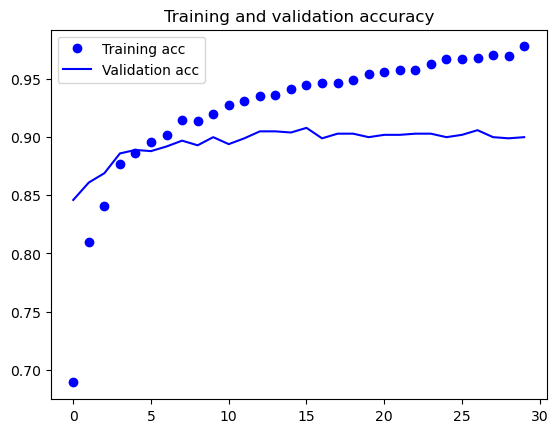

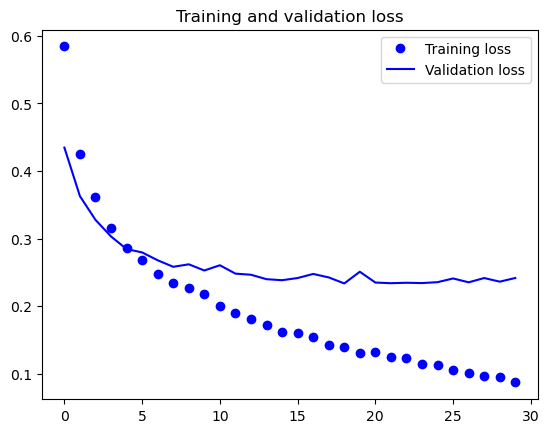

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Ré-Entrainement classifieur

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [22]:
print('This is the number of trainable weights '
      'before freezing the conv base:',
      colored(len(model.trainable_weights), "blue")
     )

This is the number of trainable weights before freezing the conv base: 30


In [23]:
conv_base.trainable = False

In [24]:
print('This is the number of trainable weights '
      'after freezing the conv base:',
      colored(len(model.trainable_weights), "blue")
     )

This is the number of trainable weights after freezing the conv base: 4


In [25]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

In [30]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Epoch 1/30
 19/100 [====>.........................] - ETA: 1:00 - loss: 0.4459 - acc: 0.8079

KeyboardInterrupt: 